In [2]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Callable, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
import torch
from torch import nn
from CustomDataset import CustomTomogramDataset
from torchvision.transforms import v2
from CustomTransform import RandomCrop3D, RandomFlip
from tqdm import tqdm

%matplotlib inline

In [3]:
class SuperRes(nn.Module):
    def __init__(self, repeats: int=3, d:int = 56, s:int = 16, scale:int = 2):
        super(SuperRes, self).__init__()
        self.repeats = repeats
        self.feature = self.conv_layer(1,d,5,1)
        self.shrinking = self.conv_layer(d,s,1,1)
        self.mapping = self.conv_layer(s,s,3,1)
        self.expanding = self.conv_layer(s,d,1,1)
        self.output = nn.ConvTranspose3d(d,1,9,scale, padding=9//2, output_padding=scale-1)    

    def forward(self, input):
        x = self.feature(input)
        x = self.shrinking(x)
        for i in range(self.repeats):
           x = self.mapping(x)
        x = self.mapping(x)
        x = self.expanding(x)
        return self.output(x)

    def conv_layer(self, layer_in, layer_out, kernel, stride):
        return nn.Sequential(nn.Conv3d(layer_in, layer_out, kernel, stride, padding=kernel//2)
                             ,nn.PReLU())

class my_model(nn.Module):
    def __init__(self):
        super(my_model, self).__init__()

        self.body = nn.Sequential(
            self.conv_layer(1, 32, kernel=5),
            self.conv_layer(32, 16, kernel=3),
        )
        #self.upscale = nn.functional.interpolate(scale_factor=2)
        self.output = self.conv_layer(16, 1)

    def forward(self, input):
        x = nn.functional.interpolate(input, scale_factor=2)
        x = self.body(x)

        return self.output(x)

    def conv_layer(
        self,
        layer_in: int,
        layer_out: int,
        kernel=1,
        stride=1,
    ) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv3d(layer_in, layer_out, kernel, stride, padding="same"),
            nn.InstanceNorm3d(layer_out),
            nn.Tanh(),
        )


def train(dataLoader, model, loss_fn, optimiser):

    size = len(dataLoader.dataset)
    model.train()

    for batch_idx, (X, y) in enumerate(dataLoader):

        X, y = X.to(device), y.to(device)
        #X, y = torch.cat(X,dim=0), torch.cat(y, dim=0)
        #X, y = X.to(device), y.to(device)

        pred = model(X)
        #print("Source Shape: ", X.shape)
        #print("Target Shape: ", y.shape)
        #print("Pred Shape: ", pred.shape)
        loss = loss_fn(pred*10000, y*10000)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        torch.cuda.empty_cache()
        if batch_idx % 3 == 0:
            loss, current = loss.item(), ((batch_idx+1)  * len(X))
            distance = abs(torch.median(torch.cdist(pred, y))/torch.median(y)*100)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Distance: {distance:>0.1f}%")


def test(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, distance = 0, 0, 0
    with torch.no_grad():

        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred*10000, y*10000).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            distance += torch.median(torch.cdist(pred, y))/torch.median(y)*100
            torch.cuda.empty_cache()

    test_loss /= num_batches
    correct /= size
    distance /= size

    
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, Distance: {distance:>3f} \n"
    )

In [4]:
transforms = v2.Compose([
    RandomCrop3D(size=(40,150,150), fixed=True)
    , RandomFlip()
])
tomograms = CustomTomogramDataset(
    "C:/Users/titan/Documents/Kaggle/CZII/CZII_files/train/static/ExperimentRuns/*/*/*.zarr",
    2,
    1,
    transforms,
    random_get=True
)

test_tomograms = CustomTomogramDataset(
    "C:/Users/titan/Documents/Kaggle/CZII/CZII_files/test/static/ExperimentRuns/*/*/*.zarr",
    2,
    1,
    transforms,
    random_get=True
)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device_ids = [i for i in range(torch.cuda.device_count())]
data_loader = torch.utils.data.DataLoader(tomograms, batch_size=3, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_tomograms, batch_size=3)

In [6]:
print(f"Using {device} device")
# min, max = tomograms.get_tensor_range()
model = SuperRes(scale=2, d=56, s=16)
model = nn.DataParallel(model, device_ids=device_ids)
model = model.to(device)

Using cuda device


In [12]:
my_list = ['module.output.bias', 'module.output.weight']
output_params = list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))
base_params = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam([{"params": [temp[1] for temp in base_params]},
                             {"params": [temp[1] for temp in output_params], "lr":1e-4}],lr=1e-3)

In [13]:
epochs = 2
progress = tqdm(range(epochs))
for epoch in progress:

    progress.set_description(f"Epoch: {epoch}")
    total_loss = 0
    distance = 0
    size = len(data_loader.dataset)
    model.train()

    for batch_idx, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)*100
        loss.backward()

        optimiser.step()
        optimiser.zero_grad()
        torch.cuda.empty_cache()
        
        total_loss += loss.item()
        avg_loss = total_loss/(batch_idx+1)
        distance += abs(torch.median(torch.cdist(pred, y))/torch.median(y))
        avg_distance = distance/(batch_idx+1)
        progress.set_postfix_str(f"Average Loss: {avg_loss:>7f}, Average Distance: {avg_distance:>0.2f}")
        
    #test(test_loader, model, loss_fn)
print("Done!")

Epoch: 0:   0%|          | 0/2 [02:20<?, ?it/s, Average Loss: 0.11065701581537724, Average Distance: 1489592.875]      


OutOfMemoryError: CUDA out of memory. Tried to allocate 578.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.49 GiB is allocated by PyTorch, and 165.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
# torch.cuda.empty_cache()
source, target = data_loader.dataset[2]

upscaled = nn.functional.interpolate(source[np.newaxis, ...], size=(92, 315, 315))
upsampled = nn.Upsample(
    scale_factor=2, recompute_scale_factor=True, mode="nearest-exact"
)(source[np.newaxis, ...])
print(source.shape)
print(target.shape)

model.eval()
gpu_source = source[np.newaxis, ...]
gpu_source = gpu_source.to(device)
model_output = model(gpu_source)

torch.Size([1, 40, 150, 150])
torch.Size([1, 80, 300, 300])


In [ ]:
tomograms[0][0][0].shape

(np.float64(-0.5), np.float64(149.5), np.float64(149.5), np.float64(-0.5))

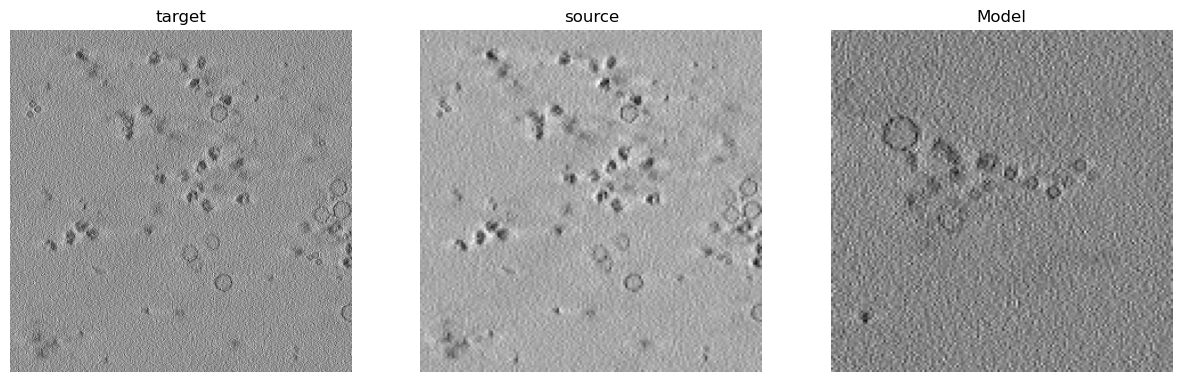

In [11]:
#source_np = source.cpu().numpy()[0]
#target_np = target[0].numpy()
#upscaled_np = upscaled.numpy()[0][0]
#model_output_np = model_output.cpu().detach().numpy()[0][0]
#upsampled_np = upsampled.numpy()[0][0]
plt.figure(figsize=(15, 15))

# Original Image
plt.subplot(1, 3, 1)
plt.title("target")
plt.imshow(target[0][20, :, :], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("source")
plt.imshow(source[0][10, :, :], cmap="gray")
plt.axis("off")
# [60, 278:308, 353:385]
# Original Image
plt.subplot(1, 3, 3)
plt.title("Model")
plt.imshow(tomograms[1][0][0][20, :, :], cmap="gray")
plt.axis("off")

#plt.subplot(2, 2, 4)
#plt.title("Model")
#plt.imshow(upsampled_np[20, :, :], cmap="gray")
#plt.axis("off")